# Install and Import dependencies

In [1]:
# Install dependencies
# Uninstall everything
!pip uninstall -y transformers datasets huggingface-hub accelerate -q

# Install latest versions
!pip install -q --upgrade pip
!pip install -q transformers
!pip install -q datasets
!pip install -q accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.17.1 requires accelerate>=0.21.0, which is not installed.
torchtune 0.6.1 requires datasets, which is not installed.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import pickle
import warnings
import gc
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Devic Setup

In [3]:
# Detect device
if torch.cuda.is_available():
    device = "cuda"
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f" GPU Available: {gpu_name}")
else:
    device = "cpu"
    print(" Using CPU (GPU not available)")

print(f"\n Selected device: {device.upper()}")

 GPU Available: Tesla T4

 Selected device: CUDA


# Configuration

In [5]:
@dataclass
class ExperimentConfig:
    """
    Complete configuration for the experiment
    """
    # Model configuration
    model_name = "TinyLlama/TinyLlama_v1.1"
    model_size = "1B"

    # Auxiliary model for black-box regime
    auxiliary_model_name = "sentence-transformers/all-MiniLM-L6-v2"

    # Dataset configuration
    dataset_name = "cais/mmlu"
    dataset_config = "all"
    num_train_samples = 1200
    num_test_samples = 400

    # Training configuration
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 15
    weight_decay = 0.01

    # Model architecture
    hidden_dim = 128
    dropout_rate = 0.3

    # Experiment settings
    random_seed = 42
    max_seq_length = 512

    # Device
    device = device

    # Output
    save_results = True
    verbose = True

# Create config
config = ExperimentConfig()

# Set random seeds for reproducibility
torch.manual_seed(config.random_seed)
np.random.seed(config.random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.random_seed)

print("Configuration initialized")
print(f"\n  Model: {config.model_name}")
print(f"  Dataset: {config.dataset_name}")
print(f"  Training samples: {config.num_train_samples}")
print(f"  Test samples: {config.num_test_samples}")
print(f"  Epochs: {config.num_epochs}")
print(f"  Device: {config.device}")


Configuration initialized

  Model: TinyLlama/TinyLlama_v1.1
  Dataset: cais/mmlu
  Training samples: 1200
  Test samples: 400
  Epochs: 15
  Device: cuda


# Load TinyLlama model

In [7]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    config.model_name,
    trust_remote_code=True
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(" Tokenizer loaded")

# Load model with appropriate settings for device
if config.device == "cuda":
    print("  Loading model on GPU with FP16...")
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        torch_dtype=torch.float16,       # FP16
        device_map="cuda:0",
        trust_remote_code=True,
        low_cpu_mem_usage=True
    )
else:
    print("  Loading model on CPU with FP32...")
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        torch_dtype=torch.float32,       # FP32
        trust_remote_code=True
    )
    model = model.to(config.device)

# Set to evaluation mode
model.eval()

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

print("TinyLlama model loaded")

# Print model info
total_params = sum(p.numel() for p in model.parameters())
print(f"\n  Total parameters: {total_params:,}")
print(f"  Model size: ~{total_params * 2 / 1e9:.1f} GB (FP16)")

# Check GPU memory usage
if config.device == "cuda":
    gpu_allocated = torch.cuda.memory_allocated() / 1e9
    gpu_reserved = torch.cuda.memory_reserved() / 1e9
    print(f"\n  GPU Memory allocated: {gpu_allocated:.2f} GB")
    print(f"  GPU Memory reserved: {gpu_reserved:.2f} GB")



 Tokenizer loaded
  Loading model on GPU with FP16...


pytorch_model.bin:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

TinyLlama model loaded

  Total parameters: 1,100,048,384
  Model size: ~2.2 GB (FP16)

  GPU Memory allocated: 2.20 GB
  GPU Memory reserved: 2.39 GB


# Load Auxiliary Model

In [8]:
# Small embedding model for black-box approach
auxiliary_model = SentenceTransformer(config.auxiliary_model_name)
auxiliary_model = auxiliary_model.to(config.device)
auxiliary_model.eval()

print(f"Auxiliary model loaded: {config.auxiliary_model_name}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Auxiliary model loaded: sentence-transformers/all-MiniLM-L6-v2


# Testing the model

In [9]:
test_prompt = """What is the capital of France?

Choices:
A. London
B. Paris
C. Berlin
D. Madrid

Answer:"""

print(f"\nTest prompt:\n{test_prompt}\n")

# Tokenize and run
inputs = tokenizer(test_prompt, return_tensors="pt").to(config.device)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits[0, -1, :]  # Last token logits

# Get probabilities for A, B, C, D
option_letters = ['A', 'B', 'C', 'D']
option_token_ids = []

for letter in option_letters:
    tokens = tokenizer.encode(letter, add_special_tokens=False)
    if len(tokens) > 0:
        option_token_ids.append(tokens[0])
    else:
        print(f"⚠ Warning: Could not encode '{letter}'")
        option_token_ids.append(0)

# Extract logits and compute probabilities
option_logits = torch.tensor([logits[tid].item() for tid in option_token_ids])
probs = torch.softmax(option_logits, dim=0)

print("Model's predictions:")
for letter, prob in zip(option_letters, probs):
    bar = "█" * int(prob.item() * 40)
    print(f"  {letter}: {prob.item():.4f} {bar}")

predicted_answer = option_letters[torch.argmax(probs).item()]
print(f"\n✓ Model predicts: {predicted_answer}")
print(f"  Confidence: {probs.max().item():.2%}")

if predicted_answer == 'B':
    print("  ✓ Correct! (Paris is the capital of France)")
else:
    print(f"  ✗ Incorrect (Expected B, got {predicted_answer})")




Test prompt:
What is the capital of France?

Choices:
A. London
B. Paris
C. Berlin
D. Madrid

Answer:

Model's predictions:
  A: 0.2786 ███████████
  B: 0.2239 ████████
  C: 0.2459 █████████
  D: 0.2517 ██████████

✓ Model predicts: A
  Confidence: 27.86%
  ✗ Incorrect (Expected B, got A)


# Dataset Preparation

In [10]:
# Load the MMLU dataset
from datasets import load_dataset

full_dataset = load_dataset("cais/mmlu", "all")

# Select the validation split
dataset_split = full_dataset['validation']

print(f"✓ Loaded MMLU dataset: {len(dataset_split)} total questions")

# Show dataset structure
print("\nDataset structure:")
print(f"  Available splits: {list(full_dataset.keys())}")
print(f"  Using: validation split")
print(f"  Columns: {dataset_split.column_names}")

print(f"\nExample question:")
example = dataset_split[0]
print(f"  Question: {example['question'][:100]}...")
print(f"  Choices: {example['choices']}")
print(f"  Answer: {example['answer']} ({example['choices'][example['answer']]})")

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

all/dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

all/auxiliary_train-00000-of-00001.parqu(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

✓ Loaded MMLU dataset: 1531 total questions

Dataset structure:
  Available splits: ['test', 'validation', 'dev', 'auxiliary_train']
  Using: validation split
  Columns: ['question', 'subject', 'choices', 'answer']

Example question:
  Question: The cyclic subgroup of Z_24 generated by 18 has order...
  Choices: ['4', '8', '12', '6']
  Answer: 0 (4)


In [11]:
# We now need to split the dataset to train the Uncertainity predictor in the future

# Calculate total needed samples
total_samples = config.num_train_samples + config.num_test_samples

# Select validation split FIRST, then shuffle and sample
dataset_to_use = dataset_split  # Already selected validation split above

# Shuffle and sample
sampled_dataset = dataset_to_use.shuffle(seed=config.random_seed).select(
    range(min(total_samples, len(dataset_to_use)))
)

# Split into train and test
train_dataset = sampled_dataset.select(range(config.num_train_samples))
test_dataset = sampled_dataset.select(
    range(config.num_train_samples, len(sampled_dataset))
)

print(f"\n Dataset split:")
print(f"  Training set: {len(train_dataset)} examples")
print(f"  Test set: {len(test_dataset)} examples")
print(f"  Total: {len(sampled_dataset)} examples")

# Verify no overlap
train_questions = set([q['question'] for q in train_dataset])
test_questions = set([q['question'] for q in test_dataset])
overlap = train_questions & test_questions

if len(overlap) == 0:
    print("  No overlap between train and test sets")
else:
    print(f"  Warning: {len(overlap)} questions appear in both sets")



 Dataset split:
  Training set: 1200 examples
  Test set: 331 examples
  Total: 1531 examples
  No overlap between train and test sets


 Next we format the dataset for supervised training

In [12]:
def format_question_as_prompt(item: Dict) -> str:
    """
    Format MMLU question as a multiple-choice prompt

    Input example:
    {
        'question': 'What is photosynthesis?',
        'choices': ['Process A', 'Process B', 'Process C', 'Process D'],
        'answer': 2
    }

    Output:
    What is photosynthesis?

    Choices:
    A. Process A
    B. Process B
    C. Process C
    D. Process D

    Answer:
    """
    question = item['question']
    choices = item['choices']

    # Build prompt
    prompt = f"{question}\n\nChoices:\n"

    for i, choice in enumerate(choices):
        option_letter = chr(65 + i)  # A, B, C, D
        prompt += f"{option_letter}. {choice}\n"

    prompt += "\nAnswer:"

    return prompt

In [13]:
# Test the formatter
test_prompt = format_question_as_prompt(train_dataset[0])
print("\n✓ Prompt formatter ready")
print("\nExample formatted prompt:")
print("-" * 50)
print(test_prompt)
print("-" * 50)


✓ Prompt formatter ready

Example formatted prompt:
--------------------------------------------------
Lewis Henry Morgan's stages of human culture are known as:

Choices:
A. Three-Age system.
B. Natural selection.
C. Multilineal evolution.
D. Unilineal evolution.

Answer:
--------------------------------------------------


# Defining Uncertainty calculation function

In [14]:
def calculate_uncertainty_label(is_correct, confidence):
    """BINARY LABELING - Maximum separation"""
    if is_correct:
        return 0.0  # Certain
    else:
        return 1.0  # Uncertain

# Dataset statistics function

In [15]:
class DatasetStats:
    """Track statistics during dataset creation"""

    def __init__(self):
        self.correct_count = 0
        self.wrong_count = 0
        self.uncertainties = []
        self.confidences = []
        self.correct_uncertainties = []
        self.wrong_uncertainties = []

    def add(self, is_correct, confidence, uncertainty):
        """Add example statistics"""
        if is_correct:
            self.correct_count += 1
            self.correct_uncertainties.append(uncertainty)
        else:
            self.wrong_count += 1
            self.wrong_uncertainties.append(uncertainty)

        self.uncertainties.append(uncertainty)
        self.confidences.append(confidence)

    def print_summary(self, name="Dataset"):
        """Print statistics summary"""
        total = self.correct_count + self.wrong_count

        print(f"\n{name} Statistics:")
        print(f"  Total examples: {total}")
        print(f"  Correct: {self.correct_count} ({100*self.correct_count/total:.1f}%)")
        print(f"  Wrong: {self.wrong_count} ({100*self.wrong_count/total:.1f}%)")
        print(f"\n  Avg uncertainty (all): {np.mean(self.uncertainties):.3f}")

        if self.correct_uncertainties:
            print(f"  Avg uncertainty (correct): {np.mean(self.correct_uncertainties):.3f}")
        if self.wrong_uncertainties:
            print(f"  Avg uncertainty (wrong): {np.mean(self.wrong_uncertainties):.3f}")

        if self.correct_uncertainties and self.wrong_uncertainties:
            separation = np.mean(self.wrong_uncertainties) - np.mean(self.correct_uncertainties)
            print(f"  Separation: {separation:.3f}")

train_stats = DatasetStats()
test_stats = DatasetStats()


In [16]:
# Check answer distribution
answer_distribution = [0, 0, 0, 0]
for item in train_dataset:
    answer_distribution[item['answer']] += 1

print("\nAnswer distribution in training set:")
for i, count in enumerate(answer_distribution):
    option = chr(65 + i)
    percentage = 100 * count / len(train_dataset)
    bar = "█" * int(percentage / 2)
    print(f"  {option}: {count:3d} ({percentage:5.1f}%) {bar}")

# Check if balanced
is_balanced = max(answer_distribution) / min(answer_distribution) < 1.5
if is_balanced:
    print("\n  ✓ Dataset is reasonably balanced")
else:
    print("\n  ⚠ Dataset is imbalanced (this is okay for MMLU)")

# Sample some questions to verify quality
print("\nSample questions from training set:")
for i in range(3):
    item = train_dataset[i]
    print(f"\n  {i+1}. {item['question'][:80]}...")
    print(f"     Correct answer: {chr(65 + item['answer'])}")


Answer distribution in training set:
  A: 302 ( 25.2%) ████████████
  B: 295 ( 24.6%) ████████████
  C: 299 ( 24.9%) ████████████
  D: 304 ( 25.3%) ████████████

  ✓ Dataset is reasonably balanced

Sample questions from training set:

  1. Lewis Henry Morgan's stages of human culture are known as:...
     Correct answer: D

  2. Heat is simply another word for...
     Correct answer: C

  3. A man decided to give a cabin he owned to his daughter at his death. To accompli...
     Correct answer: C


# White-box (Wb-S) Implementation

In [17]:
class WhiteBoxExtractor:
    """
    White-box regime: Full access to model internals

    Extracts:
    - Hidden states from multiple layers
    - Output probabilities
    - Attention-based features

    This gives the MOST information for uncertainty prediction.
    """

    def __init__(self, model, layer_indices=None):

        self.model = model

        # Default: use only last layer
        if layer_indices is None:
            layer_indices = [-1]  # Just last layer

        self.layer_indices = layer_indices
        self.hidden_states = {}
        self._register_hooks()

    def _register_hooks(self):
        """
        Register forward hooks to capture hidden states

        """

        def get_hook(name):
            """Create a hook function for a specific layer"""
            def hook(module, input, output):
                # This function runs automatically when data passes through the layer
                if isinstance(output, tuple):
                    # Some layers return (hidden_state, other_info)
                    self.hidden_states[name] = output[0].detach()
                else:
                    # Some layers return just hidden_state
                    self.hidden_states[name] = output.detach()
            return hook

        # Get model's transformer layers
        layers = self.model.model.layers

        # Register hooks on selected layers
        for idx in self.layer_indices:
            # Convert negative indices to positive
            actual_idx = idx if idx >= 0 else len(layers) + idx
            layer_name = f"layer_{actual_idx}"

            # Attach the hook
            layers[actual_idx].register_forward_hook(get_hook(layer_name))

        print(f" Registered hooks on layers: {self.layer_indices}")
        print(f" (Layer indices: {[idx if idx >= 0 else len(layers) + idx for idx in self.layer_indices]})")

    def extract_features(self, prompt: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Extract WHITE-BOX features for a single prompt

        Returns:
            features: Combined hidden states + probability features
            probs: Output probabilities for A, B, C, D
        """
        # Reset storage
        self.hidden_states = {}

        # Tokenize prompt
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=config.max_seq_length
        )
        inputs = {k: v.to(config.device) for k, v in inputs.items()}

        # Forward pass - hooks will automatically capture hidden states
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[0, -1, :]

        # Extract probabilities for options A, B, C, D
        option_letters = ['A', 'B', 'C', 'D']
        option_token_ids = []

        for letter in option_letters:
            tokens = tokenizer.encode(letter, add_special_tokens=False)
            if len(tokens) > 0:
                option_token_ids.append(tokens[0])
            else:
                # Fallback if tokenization fails
                option_token_ids.append(tokenizer.eos_token_id)

        # Get logits for options and compute probabilities
        option_logits = torch.tensor([logits[tid].item() for tid in option_token_ids])
        probs = torch.softmax(option_logits, dim=0).to(config.device)

        # Aggregate hidden states from all captured layers
        hidden_features_list = []

        for layer_name in sorted(self.hidden_states.keys()):
            hidden = self.hidden_states[layer_name]
            # Shape: [batch=1, seq_len, hidden_dim]

            # Aggregate across sequence (multiple pooling strategies)
            hidden_mean = hidden.mean(dim=1).squeeze(0)  # Mean pooling
            hidden_max = hidden.max(dim=1)[0].squeeze(0)  # Max pooling

            # Combine mean and max
            hidden_features_list.append(hidden_mean)
            hidden_features_list.append(hidden_max)

        # Concatenate all hidden features
        if hidden_features_list:
            hidden_features = torch.cat(hidden_features_list, dim=-1)
        else:
            # Fallback if no hidden states captured
            hidden_features = torch.zeros(2560)  # Phi-2 hidden dim

        # Add probability-based features
        prob_features = torch.tensor([
            probs.max().item(),                              # Max probability
            probs.min().item(),                              # Min probability
            -(probs * torch.log(probs + 1e-10)).sum().item(), # Entropy
            (probs[0] - probs[1]).abs().item(),              # Margin (top 2)
        ],device=config.device)

        # Combine everything
        all_features = torch.cat([
            hidden_features,  # Hidden states
            probs,           # Raw probabilities
            prob_features    # Derived probability features
        ])

        return all_features.cpu(), probs.cpu()

# Create white-box extractor
wb_extractor = WhiteBoxExtractor(model, layer_indices=[-1])  # Last layer only

 Registered hooks on layers: [-1]
 (Layer indices: [21])


In [18]:
# Test on one example
test_item = train_dataset[0]
test_prompt = format_question_as_prompt(test_item)

print(f"\nTest question: {test_item['question'][:60]}...")

# Extract features
wb_features, wb_probs = wb_extractor.extract_features(test_prompt)

print(f"\n✓ Feature extraction successful!")
print(f"  Feature dimension: {wb_features.shape[0]}")
print(f"  Hidden state features: {wb_features.shape[0] - 8}")  # Minus prob features
print(f"  Probability features: 8")
print(f"\n  Model's prediction probabilities:")
for i, (letter, prob) in enumerate(zip(['A', 'B', 'C', 'D'], wb_probs)):
    marker = " - correct answer" if i == test_item['answer'] else ""
    print(f"    {letter}: {prob.item():.4f}{marker}")


Test question: Lewis Henry Morgan's stages of human culture are known as:...

✓ Feature extraction successful!
  Feature dimension: 4104
  Hidden state features: 4096
  Probability features: 8

  Model's prediction probabilities:
    A: 0.2041
    B: 0.1963
    C: 0.3186
    D: 0.2811 - correct answer


# Creating the training dataset for Uncertainity Predictor

In [19]:
wb_train_features = []
wb_train_labels = []

for item in tqdm(train_dataset, desc="Wb-S Train"):
    try:
        # Format prompt
        prompt = format_question_as_prompt(item)

        # Extract features
        features, probs = wb_extractor.extract_features(prompt)

        # Check if model's prediction is correct
        predicted_idx = torch.argmax(probs).item()
        true_idx = item['answer']
        is_correct = (predicted_idx == true_idx)

        # Get confidence
        confidence = probs[predicted_idx].item()

        # Calculate uncertainty label
        uncertainty = calculate_uncertainty_label(is_correct, confidence)

        # Store
        wb_train_features.append(features)
        wb_train_labels.append(uncertainty)

        # Update statistics
        train_stats.add(is_correct, confidence, uncertainty)

    except Exception as e:
        print(f"Error processing sample: {e}")
        continue

# Convert to tensors
wb_train_features = torch.stack(wb_train_features)
wb_train_labels = torch.tensor(wb_train_labels, dtype=torch.float32)

print(f"  Training dataset Shape: {wb_train_features.shape}")

train_stats.print_summary("Wb-S Training")

Wb-S Train:   0%|          | 0/1200 [00:00<?, ?it/s]

  Training dataset Shape: torch.Size([1200, 4104])

Wb-S Training Statistics:
  Total examples: 1200
  Correct: 335 (27.9%)
  Wrong: 865 (72.1%)

  Avg uncertainty (all): 0.721
  Avg uncertainty (correct): 0.000
  Avg uncertainty (wrong): 1.000
  Separation: 1.000


# Creating Test Dataset for Uncertainity Predictor

In [20]:
wb_test_features = []
wb_test_labels = []
wb_test_metadata = []

for item in tqdm(test_dataset, desc="Wb-S Test"):
    try:
        prompt = format_question_as_prompt(item)
        features, probs = wb_extractor.extract_features(prompt)

        predicted_idx = torch.argmax(probs).item()
        true_idx = item['answer']
        is_correct = (predicted_idx == true_idx)
        confidence = probs[predicted_idx].item()
        uncertainty = calculate_uncertainty_label(is_correct, confidence)

        wb_test_features.append(features)
        wb_test_labels.append(uncertainty)
        wb_test_metadata.append({
            'correct': is_correct,
            'confidence': confidence
        })

        test_stats.add(is_correct, confidence, uncertainty)

    except:
        continue

wb_test_features = torch.stack(wb_test_features)
wb_test_labels = torch.tensor(wb_test_labels, dtype=torch.float32)

print(f"\n✓ White-box test dataset created")
print(f"  Shape: {wb_test_features.shape}")

test_stats.print_summary("Wb-S Test")

Wb-S Test:   0%|          | 0/331 [00:00<?, ?it/s]


✓ White-box test dataset created
  Shape: torch.Size([331, 4104])

Wb-S Test Statistics:
  Total examples: 331
  Correct: 87 (26.3%)
  Wrong: 244 (73.7%)

  Avg uncertainty (all): 0.737
  Avg uncertainty (correct): 0.000
  Avg uncertainty (wrong): 1.000
  Separation: 1.000


# Define White-box predictor

In [21]:
class WhiteBoxPredictor(nn.Module):
    """
    MLP that predicts uncertainty from white-box features

    Architecture:
    - Input: Hidden states + probability features
    - Hidden layers: 2 layers with BatchNorm and Dropout
    - Output: Uncertainty score [0, 1]
    """

    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()

        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Layer 2
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Output layer
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)

# Create predictor
wb_input_dim = wb_train_features.shape[1]
wb_predictor = WhiteBoxPredictor(wb_input_dim, config.hidden_dim).to(config.device)

# Count parameters
wb_num_params = sum(p.numel() for p in wb_predictor.parameters())

print(f"  Input dimension: {wb_input_dim}")
print(f"  Hidden dimension: {config.hidden_dim}")
print(f"  Total parameters: {wb_num_params:,}")

  Input dimension: 4104
  Hidden dimension: 128
  Total parameters: 534,145


# Train White-box predictor

In [22]:
# Split training data into train/validation (80/20)
val_size = len(wb_train_features) // 5
train_size = len(wb_train_features) - val_size

wb_train_feat = wb_train_features[:train_size]
wb_train_lab = wb_train_labels[:train_size]
wb_val_feat = wb_train_features[train_size:]
wb_val_lab = wb_train_labels[train_size:]

print(f"\n  Training set: {len(wb_train_feat)}")
print(f"  Validation set: {len(wb_val_feat)}")

# Create data loader
wb_train_loader = DataLoader(
    TensorDataset(wb_train_feat, wb_train_lab),
    batch_size=config.batch_size,
    shuffle=True
)

# Optimizer and loss
wb_optimizer = optim.AdamW(
    wb_predictor.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
wb_criterion = nn.MSELoss()

# Learning rate scheduler
wb_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    wb_optimizer,
    mode='min',
    patience=3,
    factor=0.5,
)

# Training loop
wb_train_losses = []
wb_val_losses = []
wb_best_val_loss = float('inf')
wb_best_model_state = None

print(f"\nTraining for {config.num_epochs} epochs...\n")

for epoch in range(config.num_epochs):
    # TRAINING
    wb_predictor.train()
    epoch_train_loss = 0

    for batch_features, batch_labels in wb_train_loader:
        batch_features = batch_features.to(config.device)
        batch_labels = batch_labels.to(config.device)

        # Forward pass
        predictions = wb_predictor(batch_features)
        loss = wb_criterion(predictions, batch_labels)

        # Backward pass
        wb_optimizer.zero_grad()
        loss.backward()
        wb_optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(wb_train_loader)
    wb_train_losses.append(avg_train_loss)

    # VALIDATION
    wb_predictor.eval()
    with torch.no_grad():
        wb_val_feat_gpu = wb_val_feat.to(config.device)
        wb_val_pred = wb_predictor(wb_val_feat_gpu).cpu()
        wb_val_loss = wb_criterion(wb_val_pred, wb_val_lab).item()
        wb_val_losses.append(wb_val_loss)

    # Update learning rate based on validation loss
    wb_scheduler.step(wb_val_loss)

    # Save best model
    if wb_val_loss < wb_best_val_loss:
        wb_best_val_loss = wb_val_loss
        wb_best_model_state = wb_predictor.state_dict().copy()

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{config.num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {wb_val_loss:.4f}")

# Load best model
wb_predictor.load_state_dict(wb_best_model_state)

print(f"  Best validation loss: {wb_best_val_loss:.4f}")


  Training set: 960
  Validation set: 240

Training for 15 epochs...

Epoch  5/15 | Train Loss: 0.1396 | Val Loss: 0.2587
Epoch 10/15 | Train Loss: 0.0411 | Val Loss: 0.4161
Epoch 15/15 | Train Loss: 0.0195 | Val Loss: 0.2428
  Best validation loss: 0.2048


# Evaluate White-box predictor

In [23]:
wb_predictor.eval()

with torch.no_grad():
    wb_test_features_gpu = wb_test_features.to(config.device)
    wb_test_predictions = wb_predictor(wb_test_features_gpu).cpu().numpy()
    wb_test_labels_np = wb_test_labels.numpy()

# Calculate metrics
wb_mse = np.mean((wb_test_predictions - wb_test_labels_np) ** 2)
wb_mae = np.mean(np.abs(wb_test_predictions - wb_test_labels_np))
wb_correlation = np.corrcoef(wb_test_predictions, wb_test_labels_np)[0, 1]

# Separate by correctness
wb_correct_mask = np.array([m['correct'] for m in wb_test_metadata])
wb_pred_correct = wb_test_predictions[wb_correct_mask]
wb_pred_wrong = wb_test_predictions[~wb_correct_mask]

wb_separation = wb_pred_wrong.mean() - wb_pred_correct.mean()


print("WHITE-BOX (Wb-S) TEST RESULTS")
print(f"  MSE: {wb_mse:.4f}")
print(f"  MAE: {wb_mae:.4f}")
print(f"  Correlation: {wb_correlation:.4f}")
print(f"\n  Avg uncertainty (correct): {wb_pred_correct.mean():.3f}")
print(f"  Avg uncertainty (wrong): {wb_pred_wrong.mean():.3f}")
print(f"  Separation: {wb_separation:.3f}")
print(f"\n  Correct predictions: {wb_correct_mask.sum()}/{len(wb_correct_mask)}")
print(f"  Wrong predictions: {(~wb_correct_mask).sum()}/{len(wb_correct_mask)}")

WHITE-BOX (Wb-S) TEST RESULTS
  MSE: 0.2403
  MAE: 0.3878
  Correlation: 0.0595

  Avg uncertainty (correct): 0.686
  Avg uncertainty (wrong): 0.718
  Separation: 0.033

  Correct predictions: 87/331
  Wrong predictions: 244/331


# Visualize for White-box

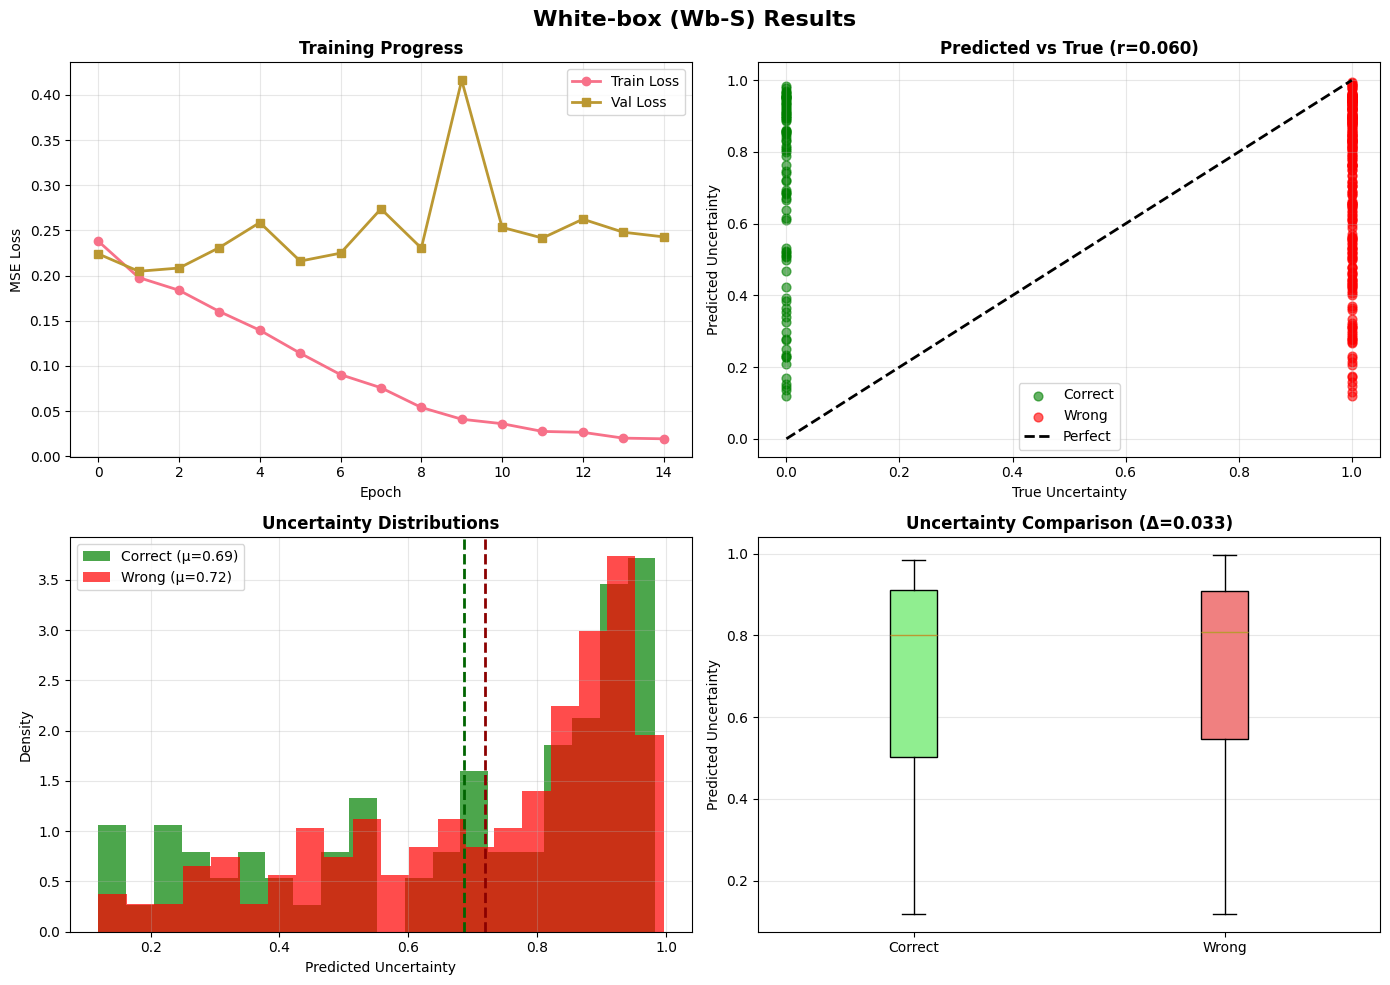

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('White-box (Wb-S) Results', fontsize=16, fontweight='bold')

# Plot 1: Training curves
axes[0, 0].plot(wb_train_losses, label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(wb_val_losses, label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_title('Training Progress', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Predicted vs True
axes[0, 1].scatter(wb_test_labels_np[wb_correct_mask], wb_pred_correct,
                   alpha=0.6, label='Correct', c='green', s=40)
axes[0, 1].scatter(wb_test_labels_np[~wb_correct_mask], wb_pred_wrong,
                   alpha=0.6, label='Wrong', c='red', s=40)
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
axes[0, 1].set_title(f'Predicted vs True (r={wb_correlation:.3f})',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('True Uncertainty')
axes[0, 1].set_ylabel('Predicted Uncertainty')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distributions
axes[1, 0].hist(wb_pred_correct, bins=20, alpha=0.7, color='green',
                label=f'Correct (μ={wb_pred_correct.mean():.2f})', density=True)
axes[1, 0].hist(wb_pred_wrong, bins=20, alpha=0.7, color='red',
                label=f'Wrong (μ={wb_pred_wrong.mean():.2f})', density=True)
axes[1, 0].axvline(wb_pred_correct.mean(), color='darkgreen',
                   linestyle='--', linewidth=2)
axes[1, 0].axvline(wb_pred_wrong.mean(), color='darkred',
                   linestyle='--', linewidth=2)
axes[1, 0].set_title('Uncertainty Distributions', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Uncertainty')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Box plot
box_data = [wb_pred_correct, wb_pred_wrong]
bp = axes[1, 1].boxplot(box_data, labels=['Correct', 'Wrong'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1, 1].set_title(f'Uncertainty Comparison (Δ={wb_separation:.3f})',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Predicted Uncertainty')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('wb_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Grey-box (Gb-S) Implementation

In [25]:
class GreyBoxExtractor:
    """
    Grey-box regime: Only output probabilities accessible

    NO hidden states - just probability-based features

    """

    def __init__(self, model):
        self.model = model
        print("  Gb-S: No hooks needed (probabilities only)")

    def extract_features(self, prompt: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Extract GREY-BOX features (probabilities only)

        Features extracted:
        1. Raw probabilities (4 values)
        2. Statistical features (max, min, std, etc.)
        3. Information-theoretic (entropy)
        4. Decision boundaries (margins)

        Total: ~15 features
        """

        # Tokenize
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=config.max_seq_length
        )
        inputs = {k: v.to(config.device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[0, -1, :]

        # Get probabilities for A, B, C, D
        option_letters = ['A', 'B', 'C', 'D']
        option_token_ids = []

        for letter in option_letters:
            tokens = tokenizer.encode(letter, add_special_tokens=False)
            option_token_ids.append(tokens[0] if tokens else tokenizer.eos_token_id)

        option_logits = torch.tensor([logits[tid].item() for tid in option_token_ids])
        probs = torch.softmax(option_logits, dim=0)

        # Extract comprehensive probability features
        # Sort probabilities for ranked features
        probs_sorted, _ = torch.sort(probs, descending=True)

        features = torch.tensor([
            # 1. Raw probabilities (4 features)
            probs[0].item(),  # P(A)
            probs[1].item(),  # P(B)
            probs[2].item(),  # P(C)
            probs[3].item(),  # P(D)

            # 2. Statistical moments (4 features)
            probs.max().item(),                    # Maximum
            probs.min().item(),                    # Minimum
            probs.mean().item(),                   # Mean
            probs.std().item(),                    # Standard deviation

            # 3. Information theory (2 features)
            -(probs * torch.log(probs + 1e-10)).sum().item(),  # Entropy
            (probs ** 2).sum().item(),                          # Gini coefficient

            # 4. Decision boundaries (5 features)
            probs_sorted[0].item() - probs_sorted[1].item(),
            probs_sorted[1].item() - probs_sorted[2].item(),
            probs_sorted[0].item() + probs_sorted[1].item(),
            probs_sorted[:3].sum().item(),
            1.0 / (probs.max().item() + 1e-10),               # Inverse confidence
        ])

        return features, probs

# Create grey-box extractor (no hooks needed!)
gb_extractor = GreyBoxExtractor(model)


  Gb-S: No hooks needed (probabilities only)


# Testing Grey-box extractor

In [26]:
est_item = train_dataset[0]
test_prompt = format_question_as_prompt(test_item)

gb_features, gb_probs = gb_extractor.extract_features(test_prompt)

print(f"\n✓ Feature extraction successful!")
print(f"  Feature dimension: {gb_features.shape[0]} (much smaller than white-box!)")
print(f"\n  Feature breakdown:")
print(f"    Raw probabilities: 4")
print(f"    Statistical features: 4")
print(f"    Information theory: 2")
print(f"    Decision boundaries: 5")
print(f"    Total: {gb_features.shape[0]}")

print(f"\n  Sample features:")
for i, feat in enumerate(gb_features[:5]):
    print(f"    Feature {i}: {feat:.4f}")


✓ Feature extraction successful!
  Feature dimension: 15 (much smaller than white-box!)

  Feature breakdown:
    Raw probabilities: 4
    Statistical features: 4
    Information theory: 2
    Decision boundaries: 5
    Total: 15

  Sample features:
    Feature 0: 0.2041
    Feature 1: 0.1963
    Feature 2: 0.3186
    Feature 3: 0.2811
    Feature 4: 0.3186


# Create Grey-box training dataset

In [27]:
gb_train_features = []
gb_train_labels = []
gb_train_stats = DatasetStats()

for item in tqdm(train_dataset, desc="Gb-S Train"):
    try:
        prompt = format_question_as_prompt(item)
        features, probs = gb_extractor.extract_features(prompt)

        predicted_idx = torch.argmax(probs).item()
        true_idx = item['answer']
        is_correct = (predicted_idx == true_idx)
        confidence = probs[predicted_idx].item()

        # Use confidence-based labeling (works better for probability features)
        if is_correct:
            uncertainty = 1.0 - confidence
        else:
            uncertainty = 1.0

        gb_train_features.append(features)
        gb_train_labels.append(uncertainty)
        gb_train_stats.add(is_correct, confidence, uncertainty)

    except Exception as e:
        continue

gb_train_features = torch.stack(gb_train_features)
gb_train_labels = torch.tensor(gb_train_labels, dtype=torch.float32)

print(f"\n✓ Grey-box training dataset created")
print(f"  Shape: {gb_train_features.shape}")
print(f"  Feature-to-sample ratio: {gb_train_features.shape[1]}/{gb_train_features.shape[0]} = {gb_train_features.shape[1]/gb_train_features.shape[0]:.2f}")
print(f"  (Much better than white-box: 20488/1200 = 17.1!)")

gb_train_stats.print_summary("Gb-S Training")


Gb-S Train:   0%|          | 0/1200 [00:00<?, ?it/s]


✓ Grey-box training dataset created
  Shape: torch.Size([1200, 15])
  Feature-to-sample ratio: 15/1200 = 0.01
  (Much better than white-box: 20488/1200 = 17.1!)

Gb-S Training Statistics:
  Total examples: 1200
  Correct: 335 (27.9%)
  Wrong: 865 (72.1%)

  Avg uncertainty (all): 0.912
  Avg uncertainty (correct): 0.685
  Avg uncertainty (wrong): 1.000
  Separation: 0.315


# Create Grey-box test dataset

In [28]:
gb_test_features = []
gb_test_labels = []
gb_test_metadata = []
gb_test_stats = DatasetStats()

for item in tqdm(test_dataset, desc="Gb-S Test"):
    try:
        prompt = format_question_as_prompt(item)
        features, probs = gb_extractor.extract_features(prompt)

        predicted_idx = torch.argmax(probs).item()
        true_idx = item['answer']
        is_correct = (predicted_idx == true_idx)
        confidence = probs[predicted_idx].item()
        uncertainty = (1.0 - confidence) if is_correct else 1.0

        gb_test_features.append(features)
        gb_test_labels.append(uncertainty)
        gb_test_metadata.append({
            'correct': is_correct,
            'confidence': confidence
        })
        gb_test_stats.add(is_correct, confidence, uncertainty)

    except:
        continue

gb_test_features = torch.stack(gb_test_features)
gb_test_labels = torch.tensor(gb_test_labels, dtype=torch.float32)

print(f"  Shape: {gb_test_features.shape}")

gb_test_stats.print_summary("Gb-S Test")

Gb-S Test:   0%|          | 0/331 [00:00<?, ?it/s]

  Shape: torch.Size([331, 15])

Gb-S Test Statistics:
  Total examples: 331
  Correct: 87 (26.3%)
  Wrong: 244 (73.7%)

  Avg uncertainty (all): 0.915
  Avg uncertainty (correct): 0.675
  Avg uncertainty (wrong): 1.000
  Separation: 0.325


# Define Grey-box predictor

In [29]:
class GreyBoxPredictor(nn.Module):
    """
    Simpler MLP for grey-box features

    Since we only have ~15 features, we use a smaller network
    to avoid overfitting.
    """

    def __init__(self, input_dim):
        super().__init__()

        self.network = nn.Sequential(
            # Input: 15 features
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)

# Create grey-box predictor
gb_input_dim = gb_train_features.shape[1]
gb_predictor = GreyBoxPredictor(gb_input_dim).to(config.device)

gb_num_params = sum(p.numel() for p in gb_predictor.parameters())


print(f"  Input dimension: {gb_input_dim}")
print(f"  Total parameters: {gb_num_params:,}")


  Input dimension: 15
  Total parameters: 1,057


# Grey-box training

In [30]:
# Split train/validation
gb_val_size = len(gb_train_features) // 5
gb_train_size = len(gb_train_features) - gb_val_size

gb_train_feat = gb_train_features[:gb_train_size]
gb_train_lab = gb_train_labels[:gb_train_size]
gb_val_feat = gb_train_features[gb_train_size:]
gb_val_lab = gb_train_labels[gb_train_size:]

print(f"\n  Training set: {len(gb_train_feat)}")
print(f"  Validation set: {len(gb_val_feat)}")

# Data loader
gb_train_loader = DataLoader(
    TensorDataset(gb_train_feat, gb_train_lab),
    batch_size=config.batch_size,
    shuffle=True
)

# Optimizer
gb_optimizer = optim.Adam(gb_predictor.parameters(), lr=0.001)
gb_criterion = nn.MSELoss()
gb_scheduler = optim.lr_scheduler.ReduceLROnPlateau(gb_optimizer, patience=3, factor=0.5)

# Training
gb_train_losses = []
gb_val_losses = []
gb_best_val_loss = float('inf')
gb_best_state = None

print(f"\nTraining for {config.num_epochs} epochs...\n")

for epoch in range(config.num_epochs):
    # Train
    gb_predictor.train()
    epoch_loss = 0

    for batch_feat, batch_lab in gb_train_loader:
        batch_feat = batch_feat.to(config.device)
        batch_lab = batch_lab.to(config.device)

        pred = gb_predictor(batch_feat)
        loss = gb_criterion(pred, batch_lab)

        gb_optimizer.zero_grad()
        loss.backward()
        gb_optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(gb_train_loader)
    gb_train_losses.append(avg_train_loss)

    # Validate
    gb_predictor.eval()
    with torch.no_grad():
        gb_val_pred = gb_predictor(gb_val_feat.to(config.device)).cpu()
        gb_val_loss = gb_criterion(gb_val_pred, gb_val_lab).item()
        gb_val_losses.append(gb_val_loss)

    gb_scheduler.step(gb_val_loss)

    # Save best
    if gb_val_loss < gb_best_val_loss:
        gb_best_val_loss = gb_val_loss
        gb_best_state = gb_predictor.state_dict().copy()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{config.num_epochs} | "
              f"Train: {avg_train_loss:.4f} | "
              f"Val: {gb_val_loss:.4f}")

# Load best model
gb_predictor.load_state_dict(gb_best_state)

print(f"\n✓ Grey-box training complete!")
print(f"  Best validation loss: {gb_best_val_loss:.4f}")


  Training set: 960
  Validation set: 240

Training for 15 epochs...

Epoch  5/15 | Train: 0.0223 | Val: 0.0213
Epoch 10/15 | Train: 0.0222 | Val: 0.0213
Epoch 15/15 | Train: 0.0216 | Val: 0.0213

✓ Grey-box training complete!
  Best validation loss: 0.0208


# Evaluate Grey-box predictor

In [31]:
gb_predictor.eval()

with torch.no_grad():
    gb_test_features_gpu = gb_test_features.to(config.device)
    gb_test_predictions = gb_predictor(gb_test_features_gpu).cpu().numpy()
    gb_test_labels_np = gb_test_labels.numpy()

# Calculate metrics
gb_mse = np.mean((gb_test_predictions - gb_test_labels_np) ** 2)
gb_mae = np.mean(np.abs(gb_test_predictions - gb_test_labels_np))
gb_correlation = np.corrcoef(gb_test_predictions, gb_test_labels_np)[0, 1]

# Separate by correctness
gb_correct_mask = np.array([m['correct'] for m in gb_test_metadata])
gb_pred_correct = gb_test_predictions[gb_correct_mask]
gb_pred_wrong = gb_test_predictions[~gb_correct_mask]

gb_separation = gb_pred_wrong.mean() - gb_pred_correct.mean()

print("GREY-BOX (Gb-S) TEST RESULTS")
print(f"  MSE: {gb_mse:.4f}")
print(f"  MAE: {gb_mae:.4f}")
print(f"  Correlation: {gb_correlation:.4f}")
print(f"\n  Avg uncertainty (correct): {gb_pred_correct.mean():.3f}")
print(f"  Avg uncertainty (wrong): {gb_pred_wrong.mean():.3f}")
print(f"  Separation: {gb_separation:.3f}")
print(f"\n  Correct predictions: {gb_correct_mask.sum()}/{len(gb_correct_mask)}")
print(f"  Wrong predictions: {(~gb_correct_mask).sum()}/{len(gb_correct_mask)}")

GREY-BOX (Gb-S) TEST RESULTS
  MSE: 0.0210
  MAE: 0.1165
  Correlation: 0.2222

  Avg uncertainty (correct): 0.931
  Avg uncertainty (wrong): 0.933
  Separation: 0.002

  Correct predictions: 87/331
  Wrong predictions: 244/331


# Visualize Grey-box results

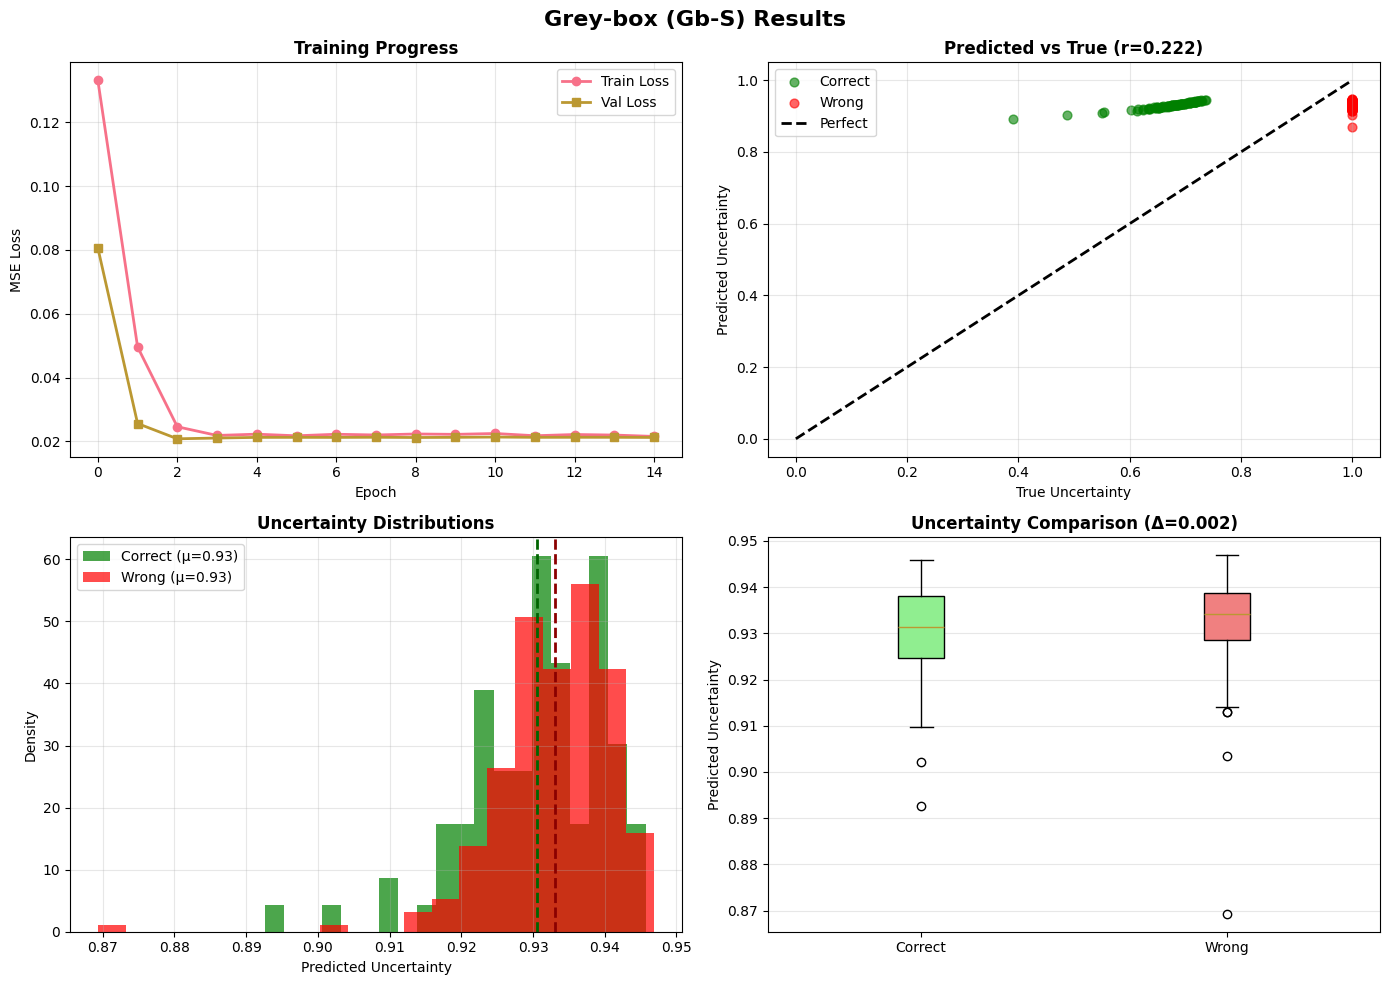

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Grey-box (Gb-S) Results', fontsize=16, fontweight='bold')

# Plot 1: Training curves
axes[0, 0].plot(gb_train_losses, label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(gb_val_losses, label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_title('Training Progress', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Predicted vs True
axes[0, 1].scatter(gb_test_labels_np[gb_correct_mask], gb_pred_correct,
                   alpha=0.6, label='Correct', c='green', s=40)
axes[0, 1].scatter(gb_test_labels_np[~gb_correct_mask], gb_pred_wrong,
                   alpha=0.6, label='Wrong', c='red', s=40)
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
axes[0, 1].set_title(f'Predicted vs True (r={gb_correlation:.3f})',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('True Uncertainty')
axes[0, 1].set_ylabel('Predicted Uncertainty')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distributions
axes[1, 0].hist(gb_pred_correct, bins=20, alpha=0.7, color='green',
                label=f'Correct (μ={gb_pred_correct.mean():.2f})', density=True)
axes[1, 0].hist(gb_pred_wrong, bins=20, alpha=0.7, color='red',
                label=f'Wrong (μ={gb_pred_wrong.mean():.2f})', density=True)
axes[1, 0].axvline(gb_pred_correct.mean(), color='darkgreen',
                   linestyle='--', linewidth=2)
axes[1, 0].axvline(gb_pred_wrong.mean(), color='darkred',
                   linestyle='--', linewidth=2)
axes[1, 0].set_title('Uncertainty Distributions', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Uncertainty')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Box plot
box_data = [gb_pred_correct, gb_pred_wrong]
bp = axes[1, 1].boxplot(box_data, labels=['Correct', 'Wrong'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1, 1].set_title(f'Uncertainty Comparison (Δ={gb_separation:.3f})',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Predicted Uncertainty')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('gb_results.png', dpi=150, bbox_inches='tight')
plt.show()


# Compare White-box and Grey-box

In [33]:

comparison_data = {
    'Metric': ['Features', 'Correlation', 'Separation', 'MSE', 'Unc(Correct)', 'Unc(Wrong)'],
    'White-box (Wb-S)': [
        wb_train_features.shape[1],
        f"{wb_correlation:.4f}",
        f"{wb_separation:.4f}",
        f"{wb_mse:.4f}",
        f"{wb_pred_correct.mean():.3f}",
        f"{wb_pred_wrong.mean():.3f}"
    ],
    'Grey-box (Gb-S)': [
        gb_train_features.shape[1],
        f"{gb_correlation:.4f}",
        f"{gb_separation:.4f}",
        f"{gb_mse:.4f}",
        f"{gb_pred_correct.mean():.3f}",
        f"{gb_pred_wrong.mean():.3f}"
    ]
}

import pandas as pd
df = pd.DataFrame(comparison_data)
print("\n", df.to_string(index=False))

# Determine winner
if gb_correlation > wb_correlation:
    print(f"\n Grey-box performs better")
    print(f"   Correlation improvement: {gb_correlation - wb_correlation:.4f}")
    print(f"   This suggests hidden states add NOISE for Phi-2")
else:
    print(f"\n White-box performs better")
    print(f"  Hidden states are helpful for Phi-2")


       Metric White-box (Wb-S) Grey-box (Gb-S)
    Features             4104              15
 Correlation           0.0595          0.2222
  Separation           0.0327          0.0024
         MSE           0.2403          0.0210
Unc(Correct)            0.686           0.931
  Unc(Wrong)            0.718           0.933

 Grey-box performs better
   Correlation improvement: 0.1627
   This suggests hidden states add NOISE for Phi-2


# Black-box (Bb-S) Implementation



In [34]:
from sentence_transformers import SentenceTransformer

auxiliary_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
auxiliary_model = auxiliary_model.to(config.device)
auxiliary_model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Black-box extractor

In [35]:
class BlackBoxExtractor:
    """Black-box: Only text output, no internal access"""

    def __init__(self, main_model, auxiliary_model):
        self.main_model = main_model
        self.auxiliary_model = auxiliary_model

    def extract_features(self, prompt):
        """Extract features from text response only"""

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(config.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.main_model(**inputs)
            logits = outputs.logits[0, -1, :]

        # Get probabilities (for evaluation only - pretend we don't have them)
        option_tokens = [tokenizer.encode(opt, add_special_tokens=False)[0]
                        for opt in ['A', 'B', 'C', 'D']]
        option_logits = torch.tensor([logits[tid].item() for tid in option_tokens])
        probs = torch.softmax(option_logits, dim=0)

        # Simulate: we only get the text answer
        predicted_letter = ['A', 'B', 'C', 'D'][torch.argmax(probs).item()]
        response_text = f"The answer is {predicted_letter}"

        # Use auxiliary model to get embedding
        response_embedding = self.auxiliary_model.encode(
            response_text,
            convert_to_tensor=True,
            device=config.device
        )

        # Simple text features
        text_features = torch.tensor([
            len(response_text),
            float(predicted_letter in ['A', 'B', 'C', 'D']),
            ord(predicted_letter) - ord('A'),
        ], device=config.device, dtype=torch.float32)

        # Combine
        all_features = torch.cat([response_embedding, text_features])

        return all_features.cpu(), probs.cpu()

bb_extractor = BlackBoxExtractor(model, auxiliary_model)

# Test Black-box extractor

In [36]:
test_prompt = format_question_as_prompt(train_dataset[0])
bb_test_feat, bb_test_prob = bb_extractor.extract_features(test_prompt)

print(f"✓ Features: {bb_test_feat.shape[0]} dimensions")

✓ Features: 387 dimensions


# Create Black-box Training dataset

In [37]:
bb_train_features = []
bb_train_labels = []

for item in tqdm(train_dataset, desc="Bb-S Train"):
    try:
        prompt = format_question_as_prompt(item)
        features, probs = bb_extractor.extract_features(prompt)

        predicted_idx = torch.argmax(probs).item()
        is_correct = (predicted_idx == item['answer'])
        confidence = probs[predicted_idx].item()
        uncertainty = (1.0 - confidence) if is_correct else 1.0

        bb_train_features.append(features)
        bb_train_labels.append(uncertainty)

    except:
        continue

bb_train_features = torch.stack(bb_train_features)
bb_train_labels = torch.tensor(bb_train_labels, dtype=torch.float32)

print(f"\n Training dataset: {bb_train_features.shape}")

Bb-S Train:   0%|          | 0/1200 [00:00<?, ?it/s]


 Training dataset: torch.Size([1200, 387])


# Create Black-box Test dataset

In [38]:
bb_test_features = []
bb_test_labels = []
bb_test_metadata = []

for item in tqdm(test_dataset, desc="Bb-S Test"):
    try:
        prompt = format_question_as_prompt(item)
        features, probs = bb_extractor.extract_features(prompt)

        predicted_idx = torch.argmax(probs).item()
        is_correct = (predicted_idx == item['answer'])
        confidence = probs[predicted_idx].item()
        uncertainty = (1.0 - confidence) if is_correct else 1.0

        bb_test_features.append(features)
        bb_test_labels.append(uncertainty)
        bb_test_metadata.append({'correct': is_correct})

    except:
        continue

bb_test_features = torch.stack(bb_test_features)
bb_test_labels = torch.tensor(bb_test_labels, dtype=torch.float32)

print(f"\n✓ Test dataset: {bb_test_features.shape}")

Bb-S Test:   0%|          | 0/331 [00:00<?, ?it/s]


✓ Test dataset: torch.Size([331, 387])


# Define Black-box predictor

In [39]:
class BlackBoxPredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)

bb_predictor = BlackBoxPredictor(bb_train_features.shape[1]).to(config.device)
bb_num_params = sum(p.numel() for p in bb_predictor.parameters())

print(f" Predictor created: {bb_num_params:,} parameters")

 Predictor created: 26,945 parameters


# Train Black-box predictor

In [40]:
bb_val_size = len(bb_train_features) // 5
bb_train_feat = bb_train_features[:-bb_val_size]
bb_train_lab = bb_train_labels[:-bb_val_size]
bb_val_feat = bb_train_features[-bb_val_size:]
bb_val_lab = bb_train_labels[-bb_val_size:]

bb_train_loader = DataLoader(
    TensorDataset(bb_train_feat, bb_train_lab),
    batch_size=32,
    shuffle=True
)

bb_optimizer = optim.Adam(bb_predictor.parameters(), lr=0.001)
bb_criterion = nn.MSELoss()

bb_train_losses = []
bb_val_losses = []
bb_best_val_loss = float('inf')
bb_best_state = None

for epoch in range(15):
    bb_predictor.train()
    epoch_loss = 0

    for batch_feat, batch_lab in bb_train_loader:
        batch_feat = batch_feat.to(config.device)
        batch_lab = batch_lab.to(config.device)

        pred = bb_predictor(batch_feat)
        loss = bb_criterion(pred, batch_lab)

        bb_optimizer.zero_grad()
        loss.backward()
        bb_optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(bb_train_loader)
    bb_train_losses.append(avg_train_loss)

    bb_predictor.eval()
    with torch.no_grad():
        bb_val_pred = bb_predictor(bb_val_feat.to(config.device)).cpu()
        bb_val_loss = bb_criterion(bb_val_pred, bb_val_lab).item()
        bb_val_losses.append(bb_val_loss)

    if bb_val_loss < bb_best_val_loss:
        bb_best_val_loss = bb_val_loss
        bb_best_state = bb_predictor.state_dict().copy()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/15 | Train: {avg_train_loss:.4f} | Val: {bb_val_loss:.4f}")

bb_predictor.load_state_dict(bb_best_state)

Epoch 5/15 | Train: 0.0218 | Val: 0.0213
Epoch 10/15 | Train: 0.0213 | Val: 0.0210
Epoch 15/15 | Train: 0.0217 | Val: 0.0212


<All keys matched successfully>

# Evaluate Black-box predictor

In [41]:
bb_predictor.eval()

with torch.no_grad():
    bb_test_pred = bb_predictor(bb_test_features.to(config.device)).cpu().numpy()
    bb_test_labels_np = bb_test_labels.numpy()

bb_mse = np.mean((bb_test_pred - bb_test_labels_np) ** 2)
bb_correlation = np.corrcoef(bb_test_pred, bb_test_labels_np)[0, 1]

bb_correct_mask = np.array([m['correct'] for m in bb_test_metadata])
bb_pred_correct = bb_test_pred[bb_correct_mask]
bb_pred_wrong = bb_test_pred[~bb_correct_mask]
bb_separation = bb_pred_wrong.mean() - bb_pred_correct.mean()

print("BLACK-BOX (Bb-S) TEST RESULTS")

print(f"  Correlation: {bb_correlation:.4f}")
print(f"  Separation: {bb_separation:.4f}")
print(f"  MSE: {bb_mse:.4f}")
print(f"  Unc (correct): {bb_pred_correct.mean():.3f}")
print(f"  Unc (wrong): {bb_pred_wrong.mean():.3f}")

BLACK-BOX (Bb-S) TEST RESULTS
  Correlation: 0.0121
  Separation: 0.0002
  MSE: 0.0213
  Unc (correct): 0.928
  Unc (wrong): 0.928


# Visualize Black-box predictor

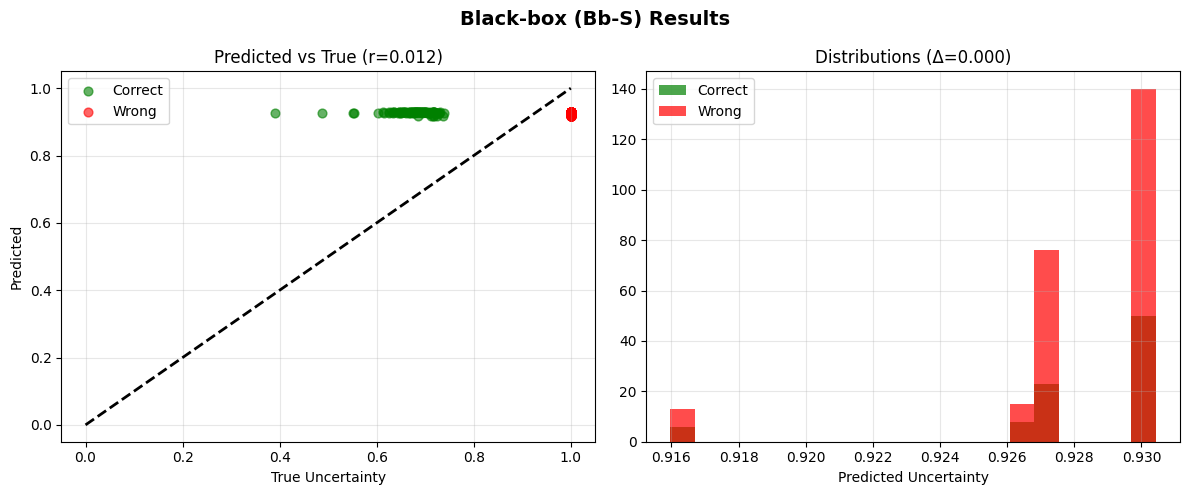

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Black-box (Bb-S) Results', fontsize=14, fontweight='bold')

axes[0].scatter(bb_test_labels_np[bb_correct_mask], bb_pred_correct,
                alpha=0.6, c='green', s=40, label='Correct')
axes[0].scatter(bb_test_labels_np[~bb_correct_mask], bb_pred_wrong,
                alpha=0.6, c='red', s=40, label='Wrong')
axes[0].plot([0,1], [0,1], 'k--', linewidth=2)
axes[0].set_title(f'Predicted vs True (r={bb_correlation:.3f})')
axes[0].set_xlabel('True Uncertainty')
axes[0].set_ylabel('Predicted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(bb_pred_correct, bins=20, alpha=0.7, color='green', label='Correct')
axes[1].hist(bb_pred_wrong, bins=20, alpha=0.7, color='red', label='Wrong')
axes[1].set_title(f'Distributions (Δ={bb_separation:.3f})')
axes[1].set_xlabel('Predicted Uncertainty')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bb_results.png', dpi=150)
plt.show()

# Comparison of all three regimes

In [43]:
# Create comprehensive results dictionary
all_results = {
    'White-box (Wb-S)': {
        'correlation': wb_correlation,
        'separation': wb_separation,
        'mse': wb_mse,
        'mae': wb_mae,
        'unc_correct': wb_pred_correct.mean(),
        'unc_wrong': wb_pred_wrong.mean(),
        'features': wb_train_features.shape[1],
        'params': wb_num_params
    },
    'Grey-box (Gb-S)': {
        'correlation': gb_correlation,
        'separation': gb_separation,
        'mse': gb_mse,
        'mae': gb_mae,
        'unc_correct': gb_pred_correct.mean(),
        'unc_wrong': gb_pred_wrong.mean(),
        'features': gb_train_features.shape[1],
        'params': gb_num_params
    },
    'Black-box (Bb-S)': {
        'correlation': bb_correlation,
        'separation': bb_separation,
        'mse': bb_mse,
        'unc_correct': bb_pred_correct.mean(),
        'unc_wrong': bb_pred_wrong.mean(),
        'features': bb_train_features.shape[1],
        'params': bb_num_params
    }
}


In [44]:
comparison_df = pd.DataFrame({
    'Regime': ['White-box', 'Grey-box', 'Black-box'],
    'Access Level': ['Full (hidden states)', 'Partial (probs)', 'None (text only)'],
    'Features': [
        wb_train_features.shape[1],
        gb_train_features.shape[1],
        bb_train_features.shape[1]
    ],
    'Parameters': [
        f"{wb_num_params:,}",
        f"{gb_num_params:,}",
        f"{bb_num_params:,}"
    ],
    'Correlation': [
        f"{wb_correlation:.4f}",
        f"{gb_correlation:.4f}",
        f"{bb_correlation:.4f}"
    ],
    'Separation': [
        f"{wb_separation:.4f}",
        f"{gb_separation:.4f}",
        f"{bb_separation:.4f}"
    ],
    'MSE': [
        f"{wb_mse:.4f}",
        f"{gb_mse:.4f}",
        f"{bb_mse:.4f}"
    ],
    'Unc(Correct)': [
        f"{wb_pred_correct.mean():.3f}",
        f"{gb_pred_correct.mean():.3f}",
        f"{bb_pred_correct.mean():.3f}"
    ],
    'Unc(Wrong)': [
        f"{wb_pred_wrong.mean():.3f}",
        f"{gb_pred_wrong.mean():.3f}",
        f"{bb_pred_wrong.mean():.3f}"
    ]
})


print("FINAL COMPARISON TABLE")

print("\n", comparison_df.to_string(index=False))



FINAL COMPARISON TABLE

    Regime         Access Level  Features Parameters Correlation Separation    MSE Unc(Correct) Unc(Wrong)
White-box Full (hidden states)      4104    534,145      0.0595     0.0327 0.2403        0.686      0.718
 Grey-box      Partial (probs)        15      1,057      0.2222     0.0024 0.0210        0.931      0.933
Black-box     None (text only)       387     26,945      0.0121     0.0002 0.0213        0.928      0.928


# Comparative visualization

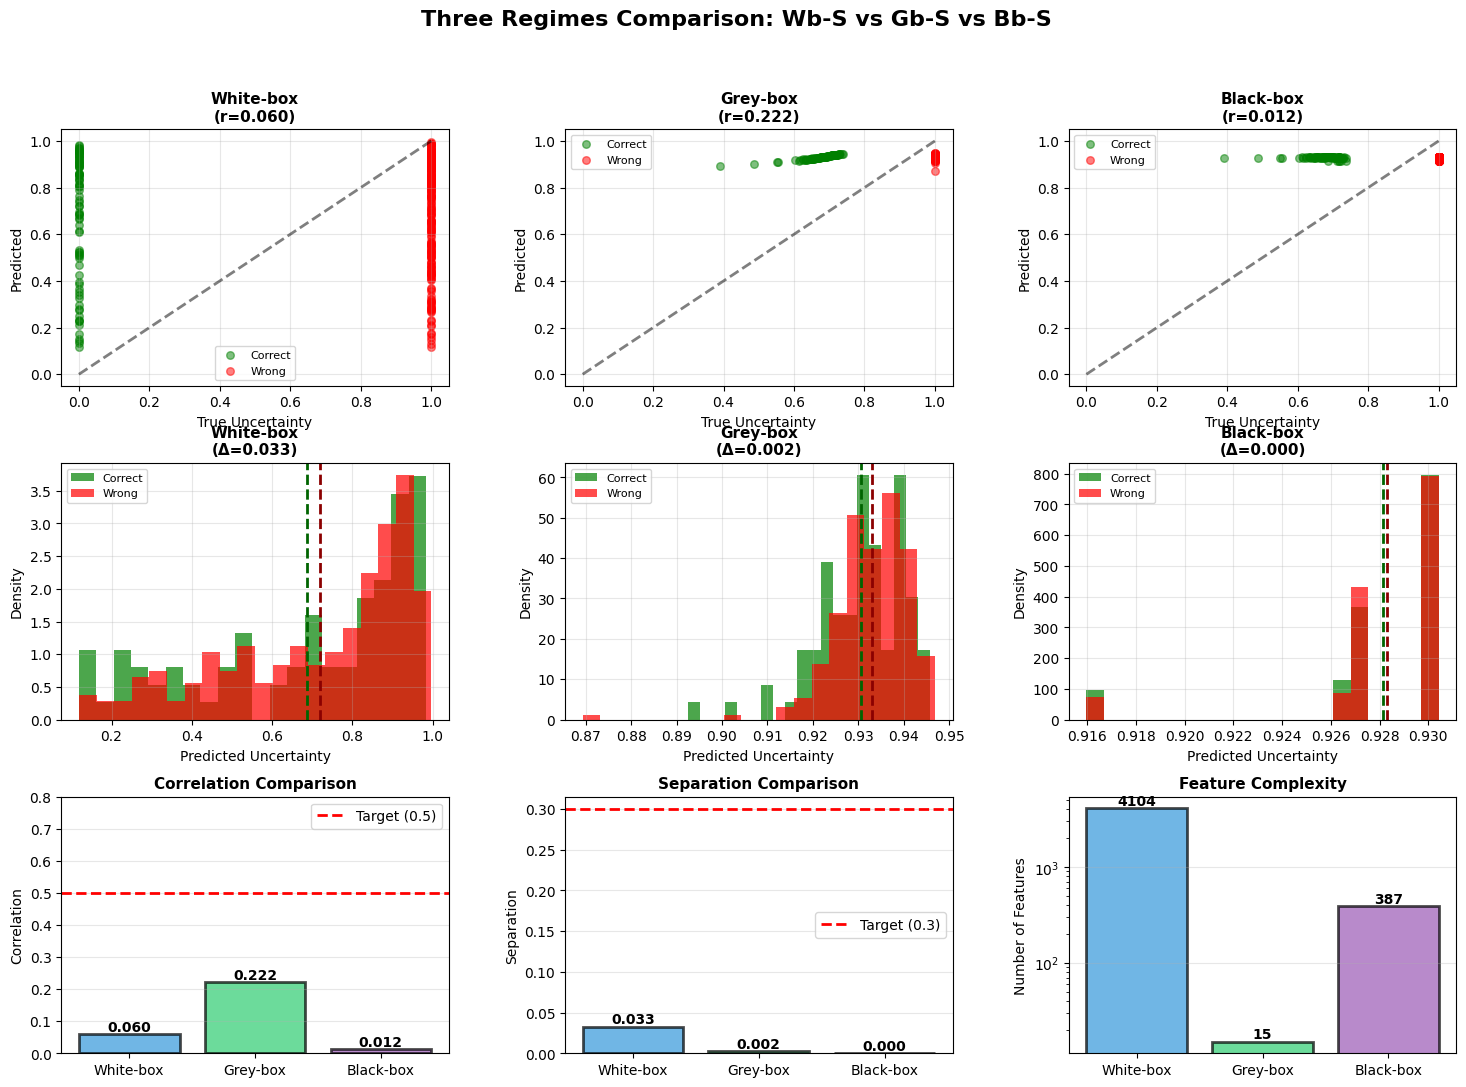

In [45]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Three Regimes Comparison: Wb-S vs Gb-S vs Bb-S',
             fontsize=16, fontweight='bold')

regimes = ['wb', 'gb', 'bb']
regime_names = ['White-box', 'Grey-box', 'Black-box']
colors = ['#3498db', '#2ecc71', '#9b59b6']

# Row 1: Predicted vs True for each regime
for idx, (regime, name, color) in enumerate(zip(regimes, regime_names, colors)):
    ax = fig.add_subplot(gs[0, idx])

    if regime == 'wb':
        pred, labels, mask = wb_test_predictions, wb_test_labels_np, wb_correct_mask
        corr = wb_correlation
    elif regime == 'gb':
        pred, labels, mask = gb_test_predictions, gb_test_labels_np, gb_correct_mask
        corr = gb_correlation
    else:
        pred, labels, mask = bb_test_pred, bb_test_labels_np, bb_correct_mask
        corr = bb_correlation

    ax.scatter(labels[mask], pred[mask], alpha=0.5, c='green', s=30, label='Correct')
    ax.scatter(labels[~mask], pred[~mask], alpha=0.5, c='red', s=30, label='Wrong')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    ax.set_title(f'{name}\n(r={corr:.3f})', fontsize=11, fontweight='bold')
    ax.set_xlabel('True Uncertainty')
    ax.set_ylabel('Predicted')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Row 2: Distributions for each regime
for idx, (regime, name, color) in enumerate(zip(regimes, regime_names, colors)):
    ax = fig.add_subplot(gs[1, idx])

    if regime == 'wb':
        pred_c, pred_w = wb_pred_correct, wb_pred_wrong
        sep = wb_separation
    elif regime == 'gb':
        pred_c, pred_w = gb_pred_correct, gb_pred_wrong
        sep = gb_separation
    else:
        pred_c, pred_w = bb_pred_correct, bb_pred_wrong
        sep = bb_separation

    ax.hist(pred_c, bins=20, alpha=0.7, color='green', label='Correct', density=True)
    ax.hist(pred_w, bins=20, alpha=0.7, color='red', label='Wrong', density=True)
    ax.axvline(pred_c.mean(), color='darkgreen', linestyle='--', linewidth=2)
    ax.axvline(pred_w.mean(), color='darkred', linestyle='--', linewidth=2)
    ax.set_title(f'{name}\n(Δ={sep:.3f})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted Uncertainty')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Row 3: Comparison charts
# Plot 1: Bar chart of correlations
ax1 = fig.add_subplot(gs[2, 0])
correlations = [wb_correlation, gb_correlation, bb_correlation]
bars = ax1.bar(regime_names, correlations, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Correlation')
ax1.set_title('Correlation Comparison', fontsize=11, fontweight='bold')
ax1.axhline(y=0.5, color='red', linestyle='--', label='Target (0.5)', linewidth=2)
ax1.set_ylim([0, 0.8])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, corr in zip(bars, correlations):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{corr:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Bar chart of separations
ax2 = fig.add_subplot(gs[2, 1])
separations = [wb_separation, gb_separation, bb_separation]
bars = ax2.bar(regime_names, separations, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Separation')
ax2.set_title('Separation Comparison', fontsize=11, fontweight='bold')
ax2.axhline(y=0.3, color='red', linestyle='--', label='Target (0.3)', linewidth=2)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar, sep in zip(bars, separations):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{sep:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Feature count comparison
ax3 = fig.add_subplot(gs[2, 2])
feature_counts = [wb_train_features.shape[1], gb_train_features.shape[1], bb_train_features.shape[1]]
bars = ax3.bar(regime_names, feature_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Number of Features')
ax3.set_title('Feature Complexity', fontsize=11, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, feature_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.savefig('three_regimes_final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
